# Mô hình Logistics phân lớp nhiều lớp

Tập nhãn $\mathcal Y = \{1,2,\ldots, C\}$

## Phân bố nhóm

Biến ngẫu nhiên $Y\sim \mathrm{Cat}(y|\theta_1,\theta_2,\ldots, \theta_C)$ tức là

$$
P(Y = c) = \theta_c, c= 1,2,\ldots, C
$$

Ví dụ: xúc sắc thì $C = 6$, $\theta_c = 1/6, \forall c$.

$$
P(Y = y) = \prod_{c=1}^C \theta_c^{\mathbb I(c=y)}
$$

## Mô hình

Có $C$ lớp —> có $C$ bộ trọng số $w_c \in \mathbb R^d, w_{c0} \in \mathbb R, c =1,2,\ldots, C$, tính hàm tuyến tính

$$
f_c(x) = w_c^T x + w_{c0}
$$

Sử dụng hàm truyền **softmax** để chuyển thành xác suất

$$
\mathcal S(z_1, z_2, \ldots z_C) = \left[\frac {e^{z_c}}{\sum_{c'=1}^C e^{z_{c'}}}\right]_{c=1,2,\ldots,C}
$$

**Mô hình xác suất**

$$
Y|X=x \sim \mathrm{Cat}(y | \mathcal S(f_1(x), f_2(x),\ldots, f_C(x)))
$$

**Suy luận:** $h^{LR}(x)$: chọn $c$ cực đại hoá $f_c(x)$ —> cực đại hoá $\mathbb P(Y=c|x)$

## Huấn luyện

### Likelihood của bộ tham số đối với dữ liệu

$$
D = \{(x_1, y_1),(x_2, y_2),\ldots,(x_n, y_n)\}
$$

$$
\begin{align*}
L(\mathbf W) &= \mathbb P(D) = \prod_{i=1}^n \mathbb P(Y=y_i|x_i)\\
&=\prod_{i=1}^n \prod_{c=1}^C\mu_{ic}^{y_{ic}}
\end{align*}
$$

trong đó đầu ra của mô hình

$$
\mu_{ic} = \frac{e^{f_c(x_i)}}{\sum_{c'=1}^C e^{f_{c'}(x_i)}}
$$

và mã hoá **one-hot** của nhãn

$$
y_{ic} = \mathbb I(c=y_i)
$$

thay $y_i \in \{1,2,\ldots,C\}$ bằng vector toàn số 0, có duy nhất 1 số 1 ở vị trí $y_i$

$$
[0, \ldots, 0, 1, 0, \ldots, 0]
$$


### Hàm lỗi (NLL)

$$
\ell(\mathbf W) = -\log L(\mathbf W) = -\sum_{i=1}^n \sum_{c=1}^C y_{ic}\log\mu_{ic}
$$

Gọi tên là hàm lỗi **entropy chéo** (cross-entropy loss - CE loss) đo khoảng cách Kullback-Leibler (KL distance) giữa hai phân bố $\mu_{ic}$ và $y_{ic}$ (trong các thư viện học máy, tham số *reduce* = "sum", còn nếu dùng "mean" thì sẽ lấy trung bình).

### Xuống đồi bằng đạo hàm

$$
\nabla_{w_c}\ell(\mathbf W) = \sum_{i=1}^n (\mu_{ic} - y_{ic})x_i
$$

$$
\nabla_{w_{c0}}\ell(\mathbf W) = \sum_{i=1}^n (\mu_{ic} - y_{ic})
$$


In [48]:
import sklearn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
data = datasets.load_digits()

In [3]:
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
X = data['data']
y = data['target']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.33, random_state=101)

In [5]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [5]:
X.shape, y.shape

((1797, 64), (1797,))

In [6]:
n = 1797 # số lượng ảnh
d = 64 # ảnh 8x8 => số chiều là 64

In [6]:
y # nhãn 

array([0, 1, 2, ..., 8, 9, 8])

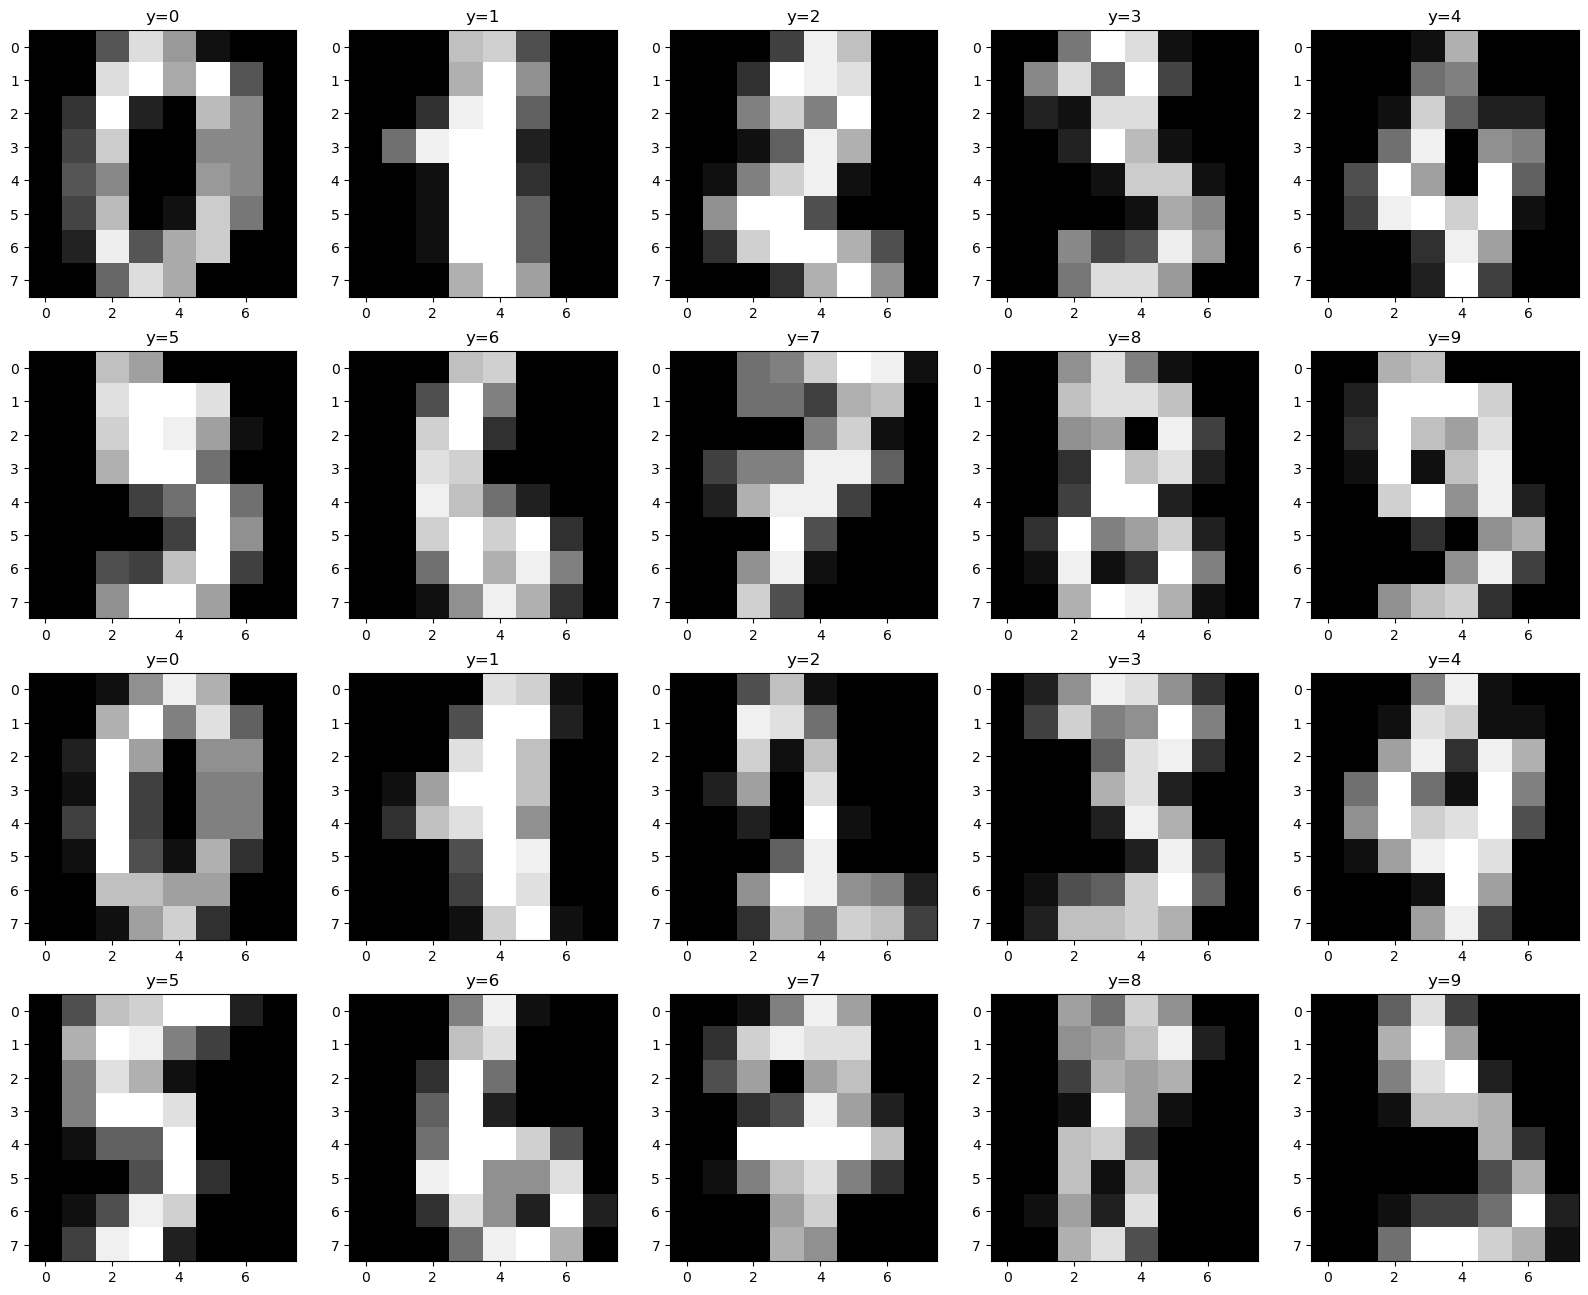

In [8]:
def draw_sample_label(X, y, ypred=None):
    X = X[:20]
    y = y[:20]
    plt.subplots(4,5,figsize=(20,16))
    for i in range(len(X)):
        plt.subplot(4,5,i+1)
        plt.imshow(X[i].reshape((8,8)), cmap='gray')

        if ypred is None:
            plt.title(f'y={y[i]}')
        else:
            plt.title(f'y={y[i]} ypred={ypred[i]}')
draw_sample_label(X,y)

In [63]:
import numpy as np
from sklearn.metrics import accuracy_score

class MultiClassLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        self.weights = np.zeros((n_features, n_classes)) 
        self.bias = np.zeros((1, n_classes)) 
        self.loss = []
        y = self.one_hot(y)

        for i in range(self.max_iter):
            z = np.dot(X, self.weights) + self.bias
            a = self.softmax(z)
            
            loss = -np.sum(y * np.log(a + 1e-8)) / n_samples  # Thêm epsilon tránh trường hợp log(0)
            self.loss.append(loss)

            dz = a - y
            dw = np.dot(X.T, dz) / n_samples
            db = np.sum(dz, axis=0, keepdims=True) / n_samples

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if i % 1000 == 0:
                print(f'Iteration {i}, Loss: {loss}')

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        a = self.softmax(z)
        return np.argmax(a, axis=1)

    def one_hot(self, y):
        y_onehot = np.zeros((y.size, y.max() + 1))
        y_onehot[np.arange(y.size), y] = 1
        return y_onehot

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) # tránh tràn số
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

model = MultiClassLogisticRegression(learning_rate=0.001, max_iter=100000)
model.fit(xtrain, ytrain)

ypred = model.predict(xtest)

print("Accuracy:", accuracy_score(ytest, ypred))

Iteration 0, Loss: 2.3025849929940505
Iteration 1000, Loss: 0.1695060722574859
Iteration 2000, Loss: 0.12099342876669257
Iteration 3000, Loss: 0.09895320856963179
Iteration 4000, Loss: 0.08531047169301281
Iteration 5000, Loss: 0.0756723831223645
Iteration 6000, Loss: 0.06834488902933601
Iteration 7000, Loss: 0.06250712449425795
Iteration 8000, Loss: 0.057702645949727946
Iteration 9000, Loss: 0.05365357708223932
Iteration 10000, Loss: 0.050179657880031585
Iteration 11000, Loss: 0.04715819105734435
Iteration 12000, Loss: 0.04450217906779343
Iteration 13000, Loss: 0.04214750820727167
Iteration 14000, Loss: 0.04004515926591673
Iteration 15000, Loss: 0.03815646135189568
Iteration 16000, Loss: 0.03645021001375274
Iteration 17000, Loss: 0.034900864134784985
Iteration 18000, Loss: 0.03348733108424945
Iteration 19000, Loss: 0.03219207759787049
Iteration 20000, Loss: 0.031000442557714697
Iteration 21000, Loss: 0.029900093255939134
Iteration 22000, Loss: 0.028880592387923152
Iteration 23000, Loss

In [9]:
# train
clf = LogisticRegression(max_iter=10000)
clf.fit(xtrain, ytrain)

LogisticRegression(max_iter=10000)

In [10]:
# suy luận
ypred = clf.predict(xtest)

In [11]:
ypred

array([7, 4, 7, 9, 1, 7, 5, 7, 1, 0, 1, 7, 1, 6, 6, 8, 4, 9, 7, 0, 7, 7,
       6, 0, 2, 3, 5, 0, 0, 2, 4, 7, 0, 4, 3, 7, 1, 3, 6, 4, 8, 8, 9, 9,
       7, 9, 8, 6, 4, 3, 1, 3, 5, 8, 1, 1, 5, 5, 4, 1, 7, 2, 4, 4, 5, 8,
       0, 8, 1, 0, 7, 6, 7, 8, 6, 5, 1, 2, 0, 6, 1, 0, 1, 9, 1, 2, 6, 8,
       3, 4, 6, 4, 1, 3, 2, 5, 7, 1, 5, 0, 0, 6, 5, 0, 9, 8, 1, 9, 3, 2,
       7, 1, 8, 4, 8, 2, 4, 1, 2, 1, 3, 8, 9, 3, 1, 6, 9, 8, 3, 2, 7, 1,
       8, 9, 5, 2, 6, 5, 0, 3, 4, 0, 5, 0, 1, 1, 7, 4, 8, 6, 1, 3, 9, 1,
       4, 9, 5, 1, 7, 6, 7, 3, 0, 7, 5, 4, 9, 9, 8, 9, 6, 1, 0, 7, 7, 4,
       8, 4, 4, 7, 5, 9, 7, 9, 8, 7, 0, 0, 7, 4, 7, 1, 0, 4, 9, 4, 5, 7,
       2, 2, 5, 2, 3, 3, 5, 3, 9, 8, 4, 3, 4, 5, 2, 1, 6, 9, 9, 5, 7, 5,
       5, 7, 6, 2, 4, 6, 9, 5, 1, 9, 2, 2, 9, 6, 5, 2, 5, 5, 6, 8, 8, 5,
       5, 1, 9, 6, 0, 5, 1, 3, 8, 8, 4, 4, 4, 0, 5, 0, 4, 7, 8, 2, 2, 2,
       5, 9, 3, 9, 3, 5, 6, 4, 3, 2, 6, 1, 1, 7, 5, 2, 8, 1, 2, 1, 8, 5,
       5, 5, 4, 4, 9, 4, 9, 8, 0, 7, 4, 3, 4, 1, 8,

In [12]:
print(f"error rate {(ytest!=ypred).sum() / len(ytest)*100:.2f}%")

error rate 3.37%


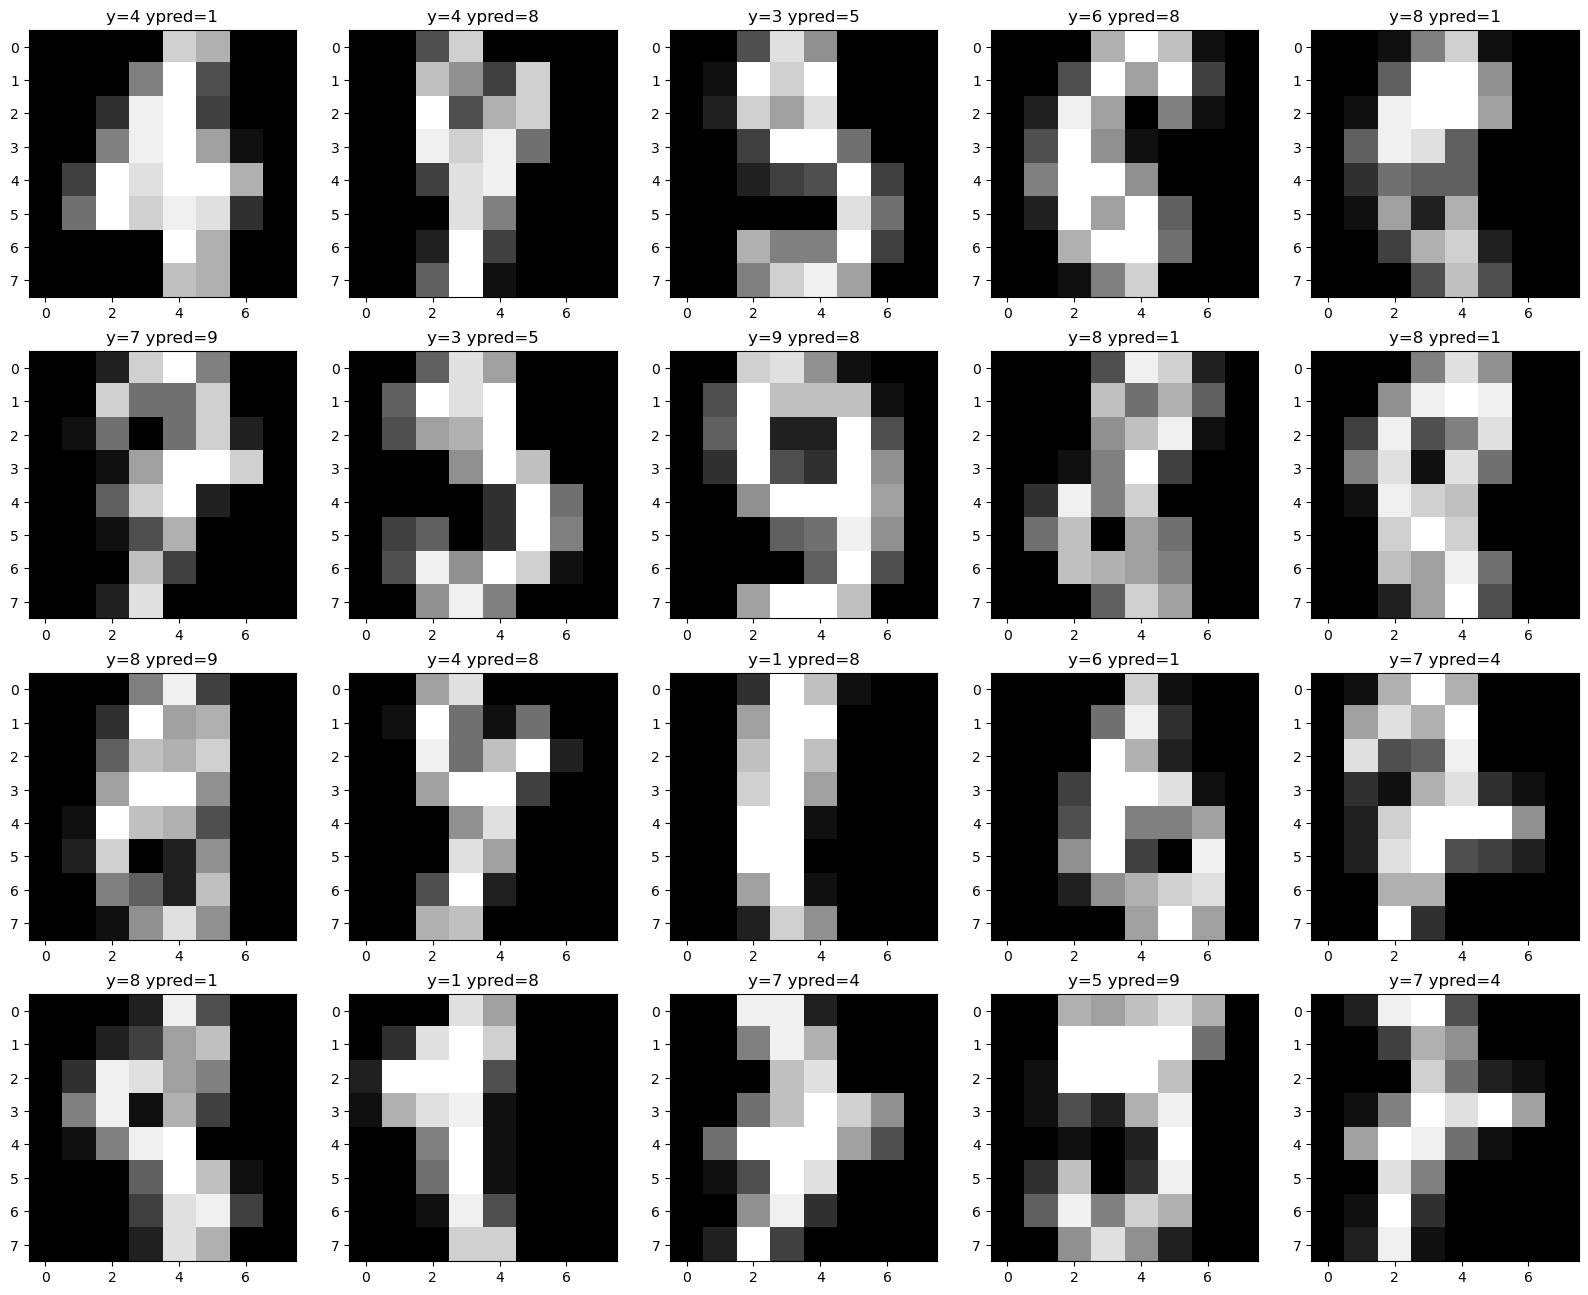

In [13]:
mask = ytest != ypred
draw_sample_label(xtest[mask], ytest[mask], ypred[mask])